In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import seaborn as sb
import numpy as np

In [2]:
sb.set(style='darkgrid', font_scale=1.2)

In [3]:
#read specific table and return dataframe
def read_db_table(table_n, connection):
    df = pd.read_sql_query("SELECT * FROM " + table_n, connection)
    return df

In [4]:
#create pivot table for 2D data
def pivot_db_table(df, cola, colb, colc):
    df_pivot = df.groupby([cola , colb]).sum().pivot_table(values=colc, index=[cola], columns=colb)
    return df_pivot

In [5]:
#create area plot, given input dataframe
def area_plot(df_plot):
    fig, ax = plt.subplots(figsize=(10,6))
    df_plot.plot.area(ax=ax)
    return fig
    

In [6]:
#create bar plot, given input dataframe
def bar_plot(df_plot, cola, colb):
    fig, ax = plt.subplots(figsize=(20,6))
    plt.bar(df_plot[cola],df_plot[colb])
    plt.xticks(rotation=90)
    return fig

In [7]:
def stacked_bar_plot(df_plot, col_order):
    fig, ax = plt.subplots(figsize=(8,6))
    df_plot = df_plot.loc[col_order,:]
    plt.bar(df_plot.columns,df_plot.iloc[0,:],label=df_plot.index[0], width = 0.7, edgecolor=None)
    cumsum = df_plot.iloc[0,:]
    for i in np.arange(1,len(df_plot)):
        plt.bar(df_plot.columns,df_plot.iloc[i,:],bottom = cumsum,label=df_plot.index[i])
        cumsum+=df_plot.iloc[i,:]
    plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xticks(rotation=90)
    return fig

In [8]:
#map powerplant categories
map_plants = dict()
map_plants['COAL'] = 'Coal'
map_plants['GEO'] = 'Geothermal'
map_plants['BE'] = 'Biomass'
map_plants['bio'] = 'Biomass'
map_plants['HYD'] = 'Hydro'
map_plants['NGA'] = 'Natural Gas'
map_plants['natural'] = 'Natural Gas'
map_plants['WND'] = 'Wind'
map_plants['wind'] = 'Wind'
map_plants['SOL'] = 'Solar'
map_plants['utilitypv'] = 'Solar'
map_plants['URN'] = 'Nuclear'
map_plants['nuclear'] = 'Nuclear'
map_plants['Batt'] = 'Battery'
map_plants['H2'] = 'Hydrogen'

In [9]:
col_order = ['Biomass','Geothermal','Hydro','Nuclear','Coal','Natural Gas','Solar','Wind','Hydrogen','Battery']

In [10]:
def plot_capacity_stacked(map_plants, col_order, db_name):
    #connect to the database
    conn = sqlite3.connect(db_name)
    df = read_db_table('Output_CapacityByPeriodAndTech', conn)
    conn.close()

    sector = 'PowerPlants'
    df_s = df.loc[df.loc[:,'sector']==sector,:]
    df_plot = pivot_db_table(df_s,'tech','t_periods', 'capacity' )
    df_plot.loc[:,'agg_tech'] = [map_plants[y] for x in df_plot.index for y in map_plants.keys() if y.lower() in x.lower()] #map agg technologies
    col_order1 = [x for x in col_order if x in df_plot.loc[:,'agg_tech'].values]
    #print(df_plot)
    df_plot = df_plot.groupby('agg_tech').sum()
    df_plot = df_plot.loc[:,df_plot.columns>=2020]
    print(df_plot.groupby('agg_tech').sum())
    fig = stacked_bar_plot(df_plot, col_order1)
    plt.ylabel('Capacity (GW)')
    return fig

t_periods          2020        2025        2030        2035        2040  \
agg_tech                                                                  
Coal         217.549940  191.737336  186.137336  186.137336  185.832336   
Geothermal     4.231000    4.231000    4.231000    4.231000    4.231000   
Hydro        103.303500  103.303500  103.303500  103.303500  103.303500   
Natural Gas  650.426517  679.337890  735.241350  845.114809  842.616808   
Nuclear       97.774654   93.267250   93.155915   87.256463   84.377346   
Solar         67.040800   70.369300   70.369300  136.499200  752.839828   
Wind          83.264000   83.264000   83.264000   83.264000   83.264000   

t_periods          2045         2050  
agg_tech                              
Coal         185.807337   185.807337  
Geothermal     4.231000     4.231000  
Hydro        103.303500   103.303500  
Natural Gas  972.662423  1103.360193  
Nuclear       79.177033    72.685918  
Solar        968.144572   968.144572  
Wind        

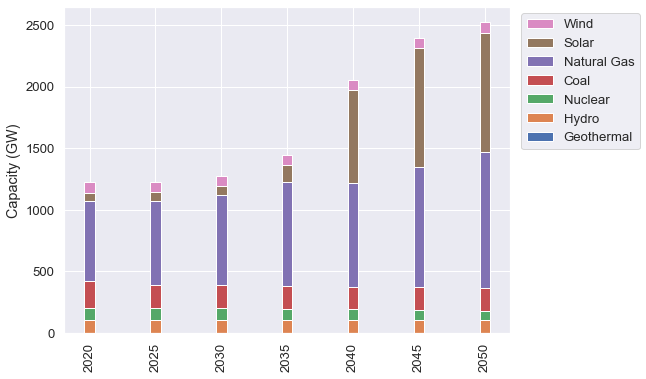

In [11]:
#specify database for scenario
db_name = 'data_files/US_National.sqlite'
fig = plot_capacity_stacked(map_plants, col_order, db_name)

t_periods          2020        2025        2030        2035        2040  \
agg_tech                                                                  
Biomass        2.528160    2.528160    2.528160    2.528160    2.528160   
Coal         217.187150  217.187150  217.187150  217.187150  217.187150   
Geothermal     1.665820    1.665820    1.665820    1.665820    1.665820   
Hydro         77.777320   77.777320   77.777320   77.777320   77.777320   
Natural Gas  437.543435  437.543435  437.543435  522.055393  522.055393   
Nuclear      102.375500  102.375500  102.375500  102.375500  102.375500   
Solar         46.719657  240.287876  478.086704  620.149086  652.689416   
Wind         103.980600  103.980600  103.980600  103.980600  307.099734   

t_periods          2045        2050  
agg_tech                             
Biomass        2.528160    2.528160  
Coal         217.187150  217.187150  
Geothermal     1.665820    1.665820  
Hydro         77.777320   77.777320  
Natural Gas  522.0553

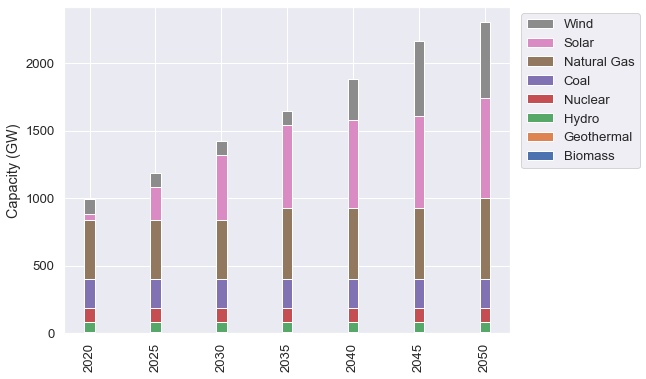

In [12]:
#specify database for scenario
db_name = 'data_files/USNational_Elec_PG.sqlite'
fig = plot_capacity_stacked(map_plants, col_order, db_name)

In [13]:
def demand_tables(db_name):
    conn = sqlite3.connect(db_name)
    df = read_db_table('Demand', conn)
    dsd = read_db_table('DemandSpecificDistribution',conn)
    conn.close()
    dsd
    df_s = df.loc[[True if x in dsd.demand_name.unique() else False for x in df.loc[:,'demand_comm'] ],:]
    df_plot = pivot_db_table(df_s,'demand_comm','periods', 'demand' )
    return df_plot

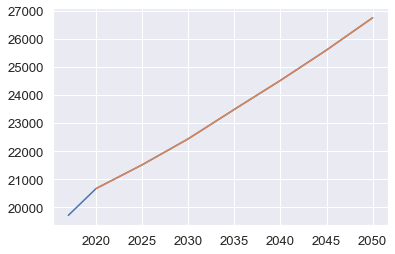

In [14]:
db_name = 'data_files/US_National.sqlite'
df_demand_o = demand_tables(db_name)
db_name = 'data_files/USNational_Elec_PG.sqlite'
df_demand_PG = demand_tables(db_name)

plt.plot(df_demand_o.sum()) 
plt.plot(df_demand_PG.sum(), label='PG') 

In [15]:
def agg_generation(db_name):
    conn = sqlite3.connect(db_name)
    df = read_db_table('Output_VFlow_Out', conn)
    conn.close()
    df_s = df.loc[df.loc[:,'sector']=='PowerPlants']
    df_plot = df_s.groupby('t_periods').sum()
    return df_plot

In [16]:
def generation(db_name, map_plants):
    conn = sqlite3.connect(db_name)
    df = read_db_table('Output_VFlow_Out', conn)
    conn.close()
    df_s = df.loc[df.loc[:,'sector']=='PowerPlants']
#    df_plot = df_s.groupby(['tech','t_periods']).sum()
    df_plot = pivot_db_table(df_s,'tech','t_periods', 'vflow_out' )
    df_plot.loc[:,'agg_tech'] = [map_plants[y] for x in df_plot.index for y in map_plants.keys() if y.lower() in x.lower()] #map agg technologies
    col_order1 = [x for x in col_order if x in df_plot.loc[:,'agg_tech'].values]
    df_plot = df_plot.groupby('agg_tech').sum()
    df_plot = df_plot.loc[:,df_plot.columns>=2020]
    fig = stacked_bar_plot(df_plot.groupby('agg_tech').sum(), col_order1)
    plt.ylabel('Generation (PJ)')
    return df_plot

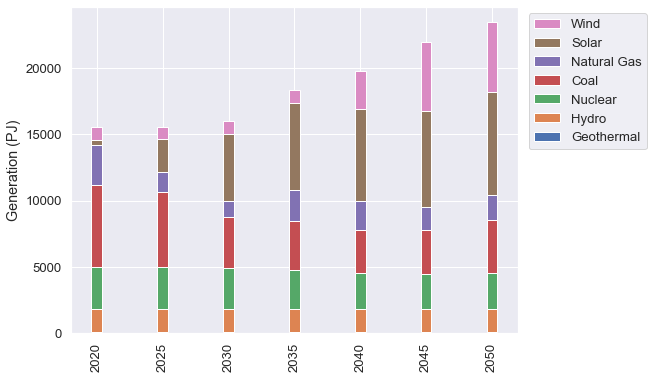

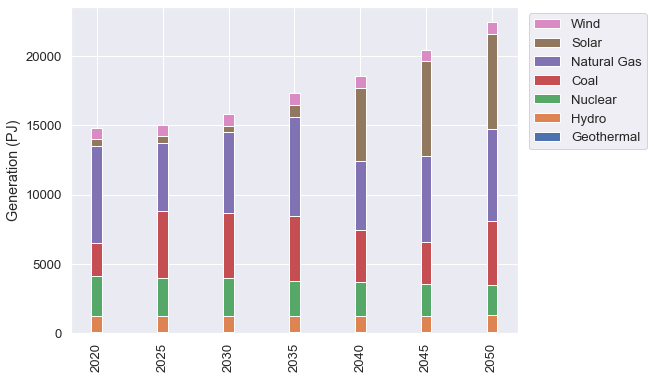

In [17]:
db_name = 'data_files/USNational_Elec_PG.sqlite'
df_plot = generation(db_name, map_plants)
db_name = 'data_files/US_National.sqlite'
df_plot = generation(db_name, map_plants)


In [18]:
db_name = 'data_files/US_National.sqlite'

conn = sqlite3.connect(db_name)
df = read_db_table('Output_VFlow_Out', conn)
conn.close()
df_s = df.loc[df.loc[:,'sector']=='PowerPlants']

In [19]:
db_name = 'data_files/USNational_Elec_PG.sqlite'

conn = sqlite3.connect(db_name)
df = read_db_table('Output_VFlow_Out', conn)
conn.close()
df_s = df.loc[df.loc[:,'sector']=='PowerPlants']
df_s.loc[:,'agg_tech'] = [map_plants[y] for x in df_s.tech for y in map_plants.keys() if y.lower() in x.lower()] #map agg technologies

df_s

/Users/aranyavenkatesh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/aranyavenkatesh/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,scenario,sector,t_periods,t_season,t_day,input_comm,tech,vintage,output_comm,vflow_out,agg_tech
0,test_run_USNational_Elec_PG,PowerPlants,2025,S4,H2,ethos_R,solar_photovoltaic_US_N_1,2015,ELCP_Renewables,2.682472,Solar
15,test_run_USNational_Elec_PG,PowerPlants,2050,S3,H13,URN_N,nuclear_US_N_3,2018,ELCP,0.722700,Nuclear
31,test_run_USNational_Elec_PG,PowerPlants,2040,S1,H12,COALSTM_N,conventional_steam_coal_US_N_6,1978,ELCP,5.828431,Coal
33,test_run_USNational_Elec_PG,PowerPlants,2020,S3,H24,ethos_R,offshore_wind_turbine_US_N_1,2016,ELCP_Renewables,0.009625,Wind
39,test_run_USNational_Elec_PG,PowerPlants,2050,S1,H15,ethos_R,landbasedwind_ltrg1_US_N_2,2045,ELCP_Renewables,19.533588,Wind
...,...,...,...,...,...,...,...,...,...,...,...
160425,test_run_USNational_Elec_PG,PowerPlants,2045,S1,H23,URN_N,nuclear_US_N_2,1974,ELCP,2.593718,Nuclear
160443,test_run_USNational_Elec_PG,PowerPlants,2030,S1,H6,ethos_R,conventional_hydroelectric_US_N_2,1938,ELCP_Renewables,7.507411,Hydro
160458,test_run_USNational_Elec_PG,PowerPlants,2040,S3,H11,COALSTM_N,conventional_steam_coal_US_N_2,1975,ELCP,22.399150,Coal
160469,test_run_USNational_Elec_PG,PowerPlants,2030,S3,H23,ethos_R,conventional_hydroelectric_US_N_3,1948,ELCP_Renewables,0.029171,Hydro


In [20]:
df_flow = df_s.groupby(['t_periods','agg_tech','t_season','t_day']).sum().reset_index()
df_flow.rename(columns={'agg_tech':'tech', 't_periods':'periods'}, inplace=True)
df_flow.loc[:,'t_day'] = df_flow.loc[:,'t_day'].str.replace('H','').map(int)
df_flow.loc[:,'t_season'] = df_flow.loc[:,'t_season'].str.replace('S','').map(int)
df_flow.loc[:,'time_concat'] = df_flow.loc[:,'t_season']*100  + df_flow.loc[:,'t_day']

df_flow.sort_values(by = ['t_season', 't_day','tech'], inplace=True)

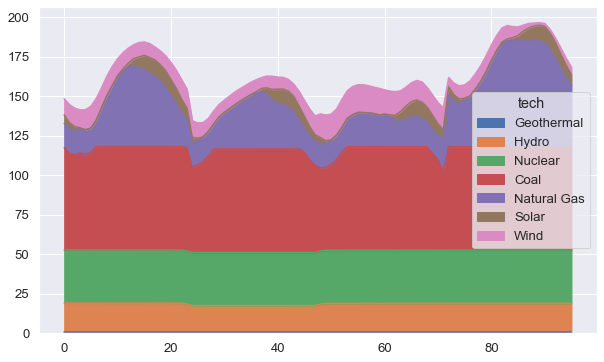

In [21]:
df_plot = df_flow[df_flow.periods==2020].pivot_table('vflow_out','tech','time_concat')
df_plot.columns = np.arange(0,96)
col_order1 = [x for x in col_order if x in df_plot.index.values]

df_plot = df_plot.loc[col_order1,:]
fig = area_plot(df_plot.transpose())

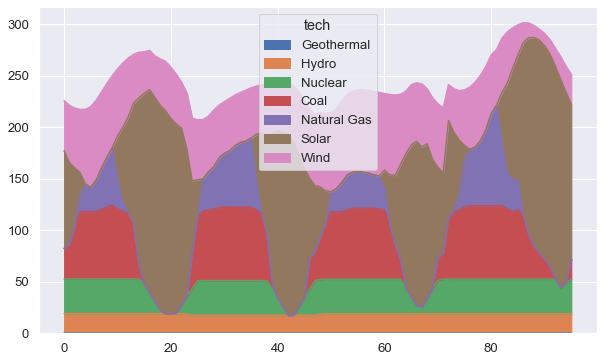

In [22]:
df_plot = df_flow[df_flow.periods==2050].pivot_table('vflow_out','tech','time_concat')
df_plot.columns = np.arange(0,96)
col_order1 = [x for x in col_order if x in df_plot.index.values]

df_plot = df_plot.loc[col_order1,:]
fig = area_plot(df_plot.transpose())

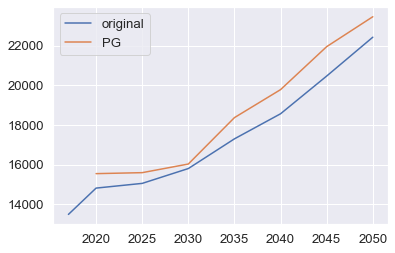

In [23]:
db_name = 'data_files/US_National.sqlite'
df_agggen_o = agg_generation(db_name)
db_name = 'data_files/USNational_Elec_PG.sqlite'
df_agggen_PG = agg_generation(db_name)

plt.plot(df_agggen_o.loc[:,'vflow_out'], label='original') 
plt.plot(df_agggen_PG.loc[:,'vflow_out'], label='PG') 
plt.legend()

In [24]:
db_name = 'data_files/US_National.sqlite'
conn = sqlite3.connect(db_name)
df = read_db_table('Output_Objective', conn)
conn.close()
df_obj_o = df['total_system_cost']
db_name = 'data_files/USNational_Elec_PG.sqlite'
conn = sqlite3.connect(db_name)
df = read_db_table('Output_Objective', conn)
conn.close()
df_obj_PG = df['total_system_cost']
df_obj_PG,df_obj_o

(0    35.4838
 Name: total_system_cost, dtype: float64,
 0    33.782113
 Name: total_system_cost, dtype: float64)

In [25]:
db_name = 'data_files/US_National.sqlite'
conn = sqlite3.connect(db_name)
df_o = read_db_table('Demand', conn)
conn.close()
db_name = 'data_files/USNational_Elec_PG.sqlite'
conn = sqlite3.connect(db_name)
df_pg = read_db_table('Demand', conn)
conn.close()
merged = df_pg.merge(df_o, indicator=True, how='outer')
merged[merged['_merge'] == 'right_only']

,periods,demand_comm,demand,demand_units,demand_notes,_merge
294,2017,GSLDEM_IND,265.100000,#PJ,#NULL,right_only
295,2017,TMDOH_E10,1200.000000,#billion miles,NULL,right_only
296,2017,TMDOH_DSL,875.000000,#billion miles,NULL,right_only
297,2017,TMDLDV,2742.223717,#billion miles,NULL,right_only
298,2017,TMDHDV_RP,28.770375,bn-pass-miles,NULL,right_only
299,2017,TMDHDV_RF,1689.626709,#billion ton miles,NULL,right_only
300,2017,TMDHDV_CT,81.014625,#billion vehicle miles,NULL,right_only
301,2017,TMDHDV_B,8.960000,#billion miles,NULL,right_only
302,2017,TMDHDV_A,1041.723111,#billion passenger miles,NULL,right_only
303,2017,RWH,1323.006661,#PJ,NULL,right_only


In [26]:
db_name = 'data_files/US_National.sqlite'
conn = sqlite3.connect(db_name)
df_o = read_db_table('Efficiency', conn)
conn.close()
db_name = 'data_files/USNational_Elec_PG.sqlite'
conn = sqlite3.connect(db_name)
df_pg = read_db_table('Efficiency', conn)
conn.close()
merged = df_pg.merge(df_o, indicator=True, how='outer')
merged[(merged['_merge'] == 'right_only') & (merged['vintage']>2017)].tech.unique()

array(['E_WNDCL4_N', 'E_URNLWR_N', 'E_SOLTHCEN_N', 'E_SOLPVENDUSE_N',
       'E_SOLPVCEN_N', 'E_SNCR_COAS_N', 'E_SNCR_COAL_N', 'E_SNCR_COAB_N',
       'E_SCR_COAS_N', 'E_SCR_COAL_N', 'E_SCR_COAB_N', 'E_PTSO2_COASM',
       'E_PTSO2_COASL', 'E_PTSO2_COALM', 'E_PTSO2_COALH', 'E_PTSO2_COABM',
       'E_PTSO2_COABL', 'E_PTSO2_COABH', 'E_PTNOXSCR_COAS',
       'E_PTNOXSCR_COAL', 'E_PTNOXSCR_COAB', 'E_PTNOXLNB_COAS',
       'E_PTNOXLNB_COAL', 'E_PTNOXLNB_COAB', 'E_PTCO2_COAS',
       'E_PTCO2_COAL', 'E_PTCO2_COAB', 'E_NGACC_CCS_N', 'E_NGAACT_N',
       'E_NGAACC_N', 'E_LNBSNCR_COAS_N', 'E_LNBSNCR_COAL_N',
       'E_LNBSNCR_COAB_N', 'E_LNBSCR_COAS_N', 'E_LNBSCR_COAL_N',
       'E_LNBSCR_COAB_N', 'E_LNB_COAS_N', 'E_LNB_COAL_N', 'E_LNB_COAB_N',
       'E_GEOBCFS_N', 'E_COALSTM_N', 'E_COALIGCC_N', 'E_COALIGCC_CCS_N',
       'E_CCR_COAS', 'E_CCR_COALIGCC_N', 'E_CCR_COAL', 'E_CCR_COAB',
       'E_EA_COAB', 'E_EA_COAS', 'E_EA_COAL', 'E_BLND_BITHML_COALIGCC_N',
       'E_BLND_LIGHM_COALIGCC_N', 'E_B

In [27]:
db_name = 'data_files/US_National.sqlite'
conn = sqlite3.connect(db_name)
df_o = read_db_table('CostVariable', conn)
conn.close()
db_name = 'data_files/USNational_Elec_PG.sqlite'
conn = sqlite3.connect(db_name)
df_pg = read_db_table('CostVariable', conn)
conn.close()
merged = df_pg.merge(df_o, indicator=True, how='outer')
merged[(merged['_merge'] == 'right_only') & (merged['vintage']<=2017) & (merged['periods']==2020)]

,periods,tech,vintage,cost_variable,cost_variable_units,cost_variable_notes,_merge
1355,2020,IMPINDCOAL,2017,3.64,#$M/PJ,None,right_only
1363,2020,IMPINDDFO,2017,20.78,#$M/PJ,None,right_only
1371,2020,IMPINDNG,2017,5.37,#$M/PJ,None,right_only
1379,2020,IMPINDGSL,2017,17.54,#$M/PJ,None,right_only
1387,2020,IMPINDLPG,2017,13.25,#$M/PJ,None,right_only
...,...,...,...,...,...,...,...
2830,2020,IMPSOY,2017,14.63,#M$/PJ,None,right_only
3030,2020,IMPTRNJTF,2017,16.20,#M$/PJ,,right_only
3101,2020,IMPCORN,2017,1.64,#M$/PJ,None,right_only
3109,2020,DRY_MILL,2017,14.16,#M$/PJ,None,right_only
